# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
np.random.seed(0)
torch.manual_seed(0)

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [2]:
# load the data set
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/train_data.pkl', 'rb') as f:
  data = pickle.load(f)

X = data['X']
y = data['y']

#standardize
X_norm = preprocessing.normalize(X)

#split -- torch tensors formed
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, stratify = y, test_size = 0.1)
X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test)


Mounted at /content/drive


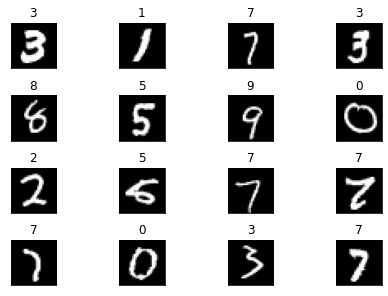

In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
f, axarr = plt.subplots(4, 4, constrained_layout = True)
transform = transforms.ToPILImage()
for i in range(4):
  for j in range(4):
    number = np.random.randint(0, np.array(X_train.shape[0]))
    drawing = axarr[i][j].imshow(np.array(X_train[number]).reshape(28, 28), cmap='gray')
    axarr[i][j].set_title(np.array(y_train)[number][0])
    drawing.axes.get_xaxis().set_visible(False)
    drawing.axes.get_yaxis().set_visible(False)


## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [18]:
# define your dataset class
class MNIST:
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
        '''self.transform = transform
        self.target_transform = target_transform
        '''
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        # returns the image as a row vector 
        '''if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        '''
        return image, label



## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [23]:
# define a child class of nn.Module for your model
# specify the architecture here itself

class Model(nn.Module) :
  def __init__(self) :
    super(Model, self).__init__()
    self.fc1 = nn.Linear(784, 200)
    self.fc2 = nn.Linear(200, 100)
    self.fc3 = nn.Linear(100, 10)
  def forward(self, x) : 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

# Test 2 layer network


## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [6]:
def train(model, optimizer, train_loader, display_step=None):
  EPOCHS = 10
  for epoch in range(EPOCHS):
    for data in train_loader:
        X, y = data

        #to reshape the y to [64] from [64,1]
        y = torch.reshape(y, (-1,))

        #print(X.shape) : torch.Size([64, 1, 28, 28])
        
        #: torch.Size([64, 1, 28, 28])

        #removing stored value of previous grad from buffer
        model.zero_grad()

        #forward-prop step
        #print(X.view(-1, 28 * 28).shape) : torch.Size([64, 784])
        output = model.forward(X.view(-1, 28 * 28).float())
        #print(output.shape) : torch.Size([64, 10])
        
        #assert output.shape == y.shape
        #negetive log likelihood loss
        loss = F.nll_loss(output, y)
        #loss = criterion(output, y)

        #back-prop step
        loss.backward()

        #update step
        optimizer.step()

    #training set loss
    print("Cost function after epoch ", epoch, "is :", loss.item())

#optimizer = optim.Adam(model.parameters(), lr=0.001)

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [7]:
def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.xavier_uniform(model.weight)
        model.bias.data.fill_(0.01)


## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [8]:
def predict(model, X_test):
    Output = model.forward(X_test.float())
    #print(Output)
    Output = Output.detach().numpy()
    return np.argmax(np.array(Output), axis = 1)

In [9]:
def accuracy(pred, labels):

    labels = labels.detach().numpy()
    labels = labels.reshape(1, labels.shape[0])
    [labels] = labels
    new_vector = (pred == labels)
    
    return np.sum(new_vector)*100./len(new_vector)

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [24]:

model = Model()
#init_weights(model)
dataset = MNIST(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, 64, shuffle = True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.CrossEntropyLoss()
train(model, optimizer,  dataloader)


Cost function after epoch  0 is : 0.32189419865608215
Cost function after epoch  1 is : 0.14980728924274445
Cost function after epoch  2 is : 0.13806964457035065
Cost function after epoch  3 is : 0.1316719651222229
Cost function after epoch  4 is : 0.06718895584344864
Cost function after epoch  5 is : 0.11091534048318863
Cost function after epoch  6 is : 0.08094590157270432
Cost function after epoch  7 is : 0.043346285820007324
Cost function after epoch  8 is : 0.007065888959914446
Cost function after epoch  9 is : 0.08914121240377426


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [25]:
pred = predict(model, X_test)
#print(pred)
print("The Accuracy is : ", accuracy(pred, y_test))



The Accuracy is :  97.13333333333334


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [ ]:
from google.colab import files
torch.save(model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [ ]:
# load the model, use predict function
